# Train script for Hybrid seq2seq model

### imports

In [1]:
%matplotlib inline

from torch.autograd import Variable
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import numpy as np

# local imports
from helpers import kl_loss
from visualize import showPlot,plotPredictions
from models import HybridVAE
from ToyDatasets.timeSeries import Sinusoids

## Define dataset loader

In [2]:
batch_size = 256
num_steps = 16
dataset_size = 20000

data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size),batch_size=batch_size,shuffle=True)
valid_data_loader = DataLoader(Sinusoids(num_steps,virtual_size=dataset_size),batch_size=batch_size,shuffle=True)

batch_loader = iter(data_loader)
valid_batch_loader = iter(valid_data_loader)

## Define model

In [3]:
model = HybridVAE(conv_size=128,rnn_size=128,latent_size=64)
print("Number of trainable parameters {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# test forward pass
try:
    initial_batch = batch_loader.next()
    x = Variable(initial_batch).type(torch.FloatTensor).transpose(1,0)
    test,_,_ = model(x)
    assert (test.shape[0] == x.shape[0] and test.shape[1] == x.shape[1] and test.shape[2] == x.shape[2])
    print("Forward pass succesfull")
except:
    print("Error in forward pass. Output should have shape: {} but had {}".format(x.contiguous().view(-1).shape,test.view(-1).shape))

Number of trainable parameters 2045698
Forward pass succesfull


## Define optimizer and loss

In [4]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()

## Define trainer

In [5]:
def train(batch_loader,valid_batch_loader,model,optimizer,loss_fn,n_iters,print_every=100):
    train_data = {"x":[],"recon_x":[]}
    valid_data = {"x":[],"recon_x":[]}
    plot_losses = []
    plot_losses_valid = []
    beta_start_inc = int(n_iters*0.4)
    beta_weight = 5e-4
    beta_max = 0.1
    beta_inc = 2e-7
    alpha_weight = 0.3
    # start training and evaluating
    for i in range(1,n_iters+1):
        if i > beta_start_inc and beta_weight < beta_max:
            beta_weight += beta_inc
        # train
        try:
            batch = next(batch_loader)
        except StopIteration:
            batch_loader = iter(data_loader)
            batch = next(batch_loader)
        x = Variable(batch).type(torch.FloatTensor).transpose(1,0)
        model.train()
        optimizer.zero_grad()
        recon_x,qz,aux_x = model(x)
        x_pl = x.contiguous().view(-1)
        recon_x_pl = recon_x.contiguous().view(-1)
        aux_x_pl = aux_x.contiguous().view(-1)
        r_loss = loss_fn(recon_x_pl,x_pl)
        kl = kl_loss(qz)
        aux_loss = loss_fn(aux_x_pl,x_pl)
        loss = r_loss + beta_weight * kl + alpha_weight * aux_loss
        loss.backward()
        optimizer.step()
        train_data["x"] = x.squeeze(2)
        train_data["recon_x"] = recon_x.squeeze(2)
        if i % print_every == 0:
            plot_losses.append(loss.data[0])
            print('\nTrain ({0:d} {1:d}%) loss: {2:.4f} r_loss: {3:.4f} kl: {4:.4f} aux_loss: {5:.4f}'.format(i,int(i/n_iters*100),loss.data[0],r_loss.data[0],kl.data[0],aux_loss.data[0]))
        
        # eval
        try:
            batch = next(valid_batch_loader)
        except StopIteration:
            valid_batch_loader = iter(valid_data_loader)
            batch = next(valid_batch_loader)
        x = Variable(batch).type(torch.FloatTensor).transpose(1,0)
        model.eval()
        recon_x,qz,aux_x = model(x)
        x_pl = x.contiguous().view(-1)
        recon_x_pl = recon_x.contiguous().view(-1)
        aux_x_pl = aux_x.contiguous().view(-1)
        r_loss = loss_fn(recon_x_pl,x_pl)
        kl = kl_loss(qz)
        aux_loss = loss_fn(aux_x_pl,x_pl)
        loss = r_loss + beta_weight * kl + alpha_weight * aux_loss
        valid_data["x"] = x.squeeze(2)
        valid_data["recon_x"] = recon_x.squeeze(2)
        if i % print_every == 0:
            plot_losses_valid.append(loss.data[0])
            print('Valid ({0:d} {1:d}%) loss: {2:.4f} r_loss: {3:.4f} kl: {4:.4f} aux_loss: {5:.4f}'.format(i,int(i/n_iters*100),loss.data[0],r_loss.data[0],kl.data[0],aux_loss.data[0]))
    showPlot(plot_losses,plot_losses_valid,yu=0.5)
    plotPredictions(train_data['x'],train_data['recon_x'],xu=num_steps,yu=1)
    plotPredictions(valid_data['x'],valid_data['recon_x'],xu=num_steps,yu=1)


Train (100 10%) loss: 0.0847 r_loss: 0.0629 kl: 12.3547 aux_loss: 0.0520
Valid (100 10%) loss: 0.0837 r_loss: 0.0620 kl: 13.3198 aux_loss: 0.0499

Train (200 20%) loss: 0.0481 r_loss: 0.0316 kl: 20.3021 aux_loss: 0.0213
Valid (200 20%) loss: 0.0473 r_loss: 0.0310 kl: 20.8229 aux_loss: 0.0194

Train (300 30%) loss: 0.0297 r_loss: 0.0155 kl: 20.4559 aux_loss: 0.0132
Valid (300 30%) loss: 0.0319 r_loss: 0.0165 kl: 20.7976 aux_loss: 0.0166

Train (400 40%) loss: 0.0256 r_loss: 0.0121 kl: 20.1120 aux_loss: 0.0115
Valid (400 40%) loss: 0.0242 r_loss: 0.0111 kl: 19.3390 aux_loss: 0.0115

Train (500 50%) loss: 0.0232 r_loss: 0.0108 kl: 17.7966 aux_loss: 0.0103
Valid (500 50%) loss: 0.0236 r_loss: 0.0112 kl: 17.4742 aux_loss: 0.0111

Train (600 60%) loss: 0.0212 r_loss: 0.0093 kl: 16.6769 aux_loss: 0.0096
Valid (600 60%) loss: 0.0226 r_loss: 0.0104 kl: 17.4244 aux_loss: 0.0095

Train (700 70%) loss: 0.0208 r_loss: 0.0087 kl: 16.9348 aux_loss: 0.0089
Valid (700 70%) loss: 0.0210 r_loss: 0.0087 

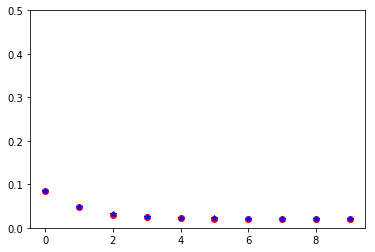

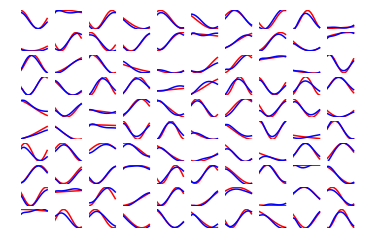

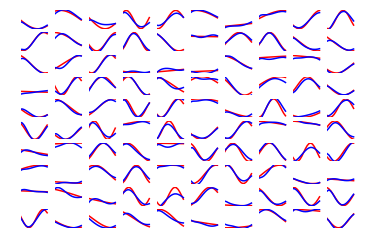

In [6]:
# use at least 1000 iterations to get good results
train(batch_loader,valid_batch_loader,model,optimizer,loss_fn,1000,print_every=100)